This is an example of an HOA 7BA lattice.

SimpleStorageRing will calculate 
* linear optics, 
* **driving terms**, (using the RDT fluctuation data, the number of iterations for calculating crossing terms is reduced from $N(N+1)/2$ to $N$, and the calculation speed is greatly increased). 
* **fluctuation of driving terms**
* higher-order chromaticities (by calculating the tunes of off-momentum closed orbit).

The unit of angle is radian.

For multipoles, $k_n = \dfrac{q}{P_0} \dfrac{\partial^n B_y}{\partial x^n}$


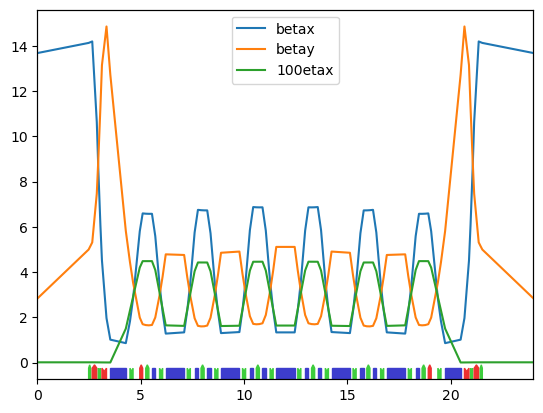

In [1]:
import simplestoragering as ssr
import numpy as np
import matplotlib.pyplot as plt
import time
from example import generate_ring  # the number of slices affects the results of driving terms and higher-order chromaticities


cell = generate_ring()
cell.linear_optics()  # the number of periods of cells is 14. calculate the ring data using one cell.
ssr.plot_lattice(cell, ['betax', 'betay', '100etax'])
ring = cell * 14  
ring.linear_optics()     # calculate the ring data using all elements of the ring.
# print(ring)

## compute driving terms.

simplestoragering calculates the 3rd- and 4th-order RDTs and their fluctuations.

The pertubation of the $i$-th sextupole in the normal form is denoted as $\hat{V}_i$. 
The third-order generator for the ring Hamiltonian is $h_{3} = \sum_{i=1}^N \hat{V}_i$, where $N$ is the number of sextupoles of the ring.
The fourth-order generator is contributed by the crossing terms as 
$$h_4 = \sum_{j>i=1}^{N}\left[\hat{V}_i, \hat{V}_j\right] = \sum_{j=2}^{N}\left[\sum_{i=1}^{j-1}\hat{V}_i, \hat{V}_j\right]$$

By recording the the third-order RDT fluctuations, we can directly obtain the values of $\sum_{i=1}^{j-1}\hat{V}_i$,
reducing the calculation of the 4th-order RDTs to a **single loop** and **greatly increasing the calculation speed**.

The number of iterations is reduced from $N(N+1)/2$ to $N$.

As a comparasion, `another_method_driving_terms()` use the formula in ELEGANT and [Chun-xi Wang, 2012] to calculate the crossing terms.

In addition, SimpleStorageRing can **calculate multi-period RDTs**, further reducing computation time. The formula for calculating multi-period RDTs is referenced from [inside_OPA.pdf](https://ados.web.psi.ch/opa).

In [2]:
ring.linear_optics()
t1 = time.time()
ring.driving_terms(printout=False)
t2 = time.time()
print(f'time = {t2 - t1:.3f} seconds.    Calculate using RDT fluctuations data.')
# This method using the ELEGANT formula.
t1 = time.time()
rdts_another_method = ring.another_method_driving_terms(printout=False)
t2 = time.time()
print(f'time = {t2 - t1:.3f} seconds.    Another method calculates one-turn RDTs.')

# SimpleStorageRing can calculate can calculate multi-period RDTs
# further reducing computation time.
# The formula for calculating multi-period RDTs is referenced from [inside_OPA.pdf](https://ados.web.psi.ch/opa).
t1 = time.time()
rdts = cell.driving_terms(printout=False)
rdts.set_periods(n_periods=14)
t2 = time.time()
print(f'time = {t2 - t1:.3f} seconds.    Calculate using RDT fluctuations data with one cell.')

# The ADTSs are driven by h22000 h11110 and h00220
print(f"\n{'Calculate ADTSs with RDTs':>50}:\n{'dQxx':>20}: {-4 * rdts['h22000'] / np.pi:.0f}, dQxy: {-2 * rdts['h11110'] / np.pi:.0f}, dQyy: {-4 * rdts['h00220'] / np.pi:.0f}")

# There is another method to calculate ADTS terms
# which uses the formula in [CERN8805] and [SLS09/97].
# But this is slower especially when the number of sextupoles or slices of sextupoles is large.
t1 = time.time()
adts = ring.adts(n_periods=1, printout=False)
t2 = time.time()
print(f'time = {t2 - t1:.3f} seconds.    Calculate ADTSs with [CERN8805] and [SLS09/97] formula.')
print('                ', end='')
for k, v in adts.items():
    print(f'{k}: {v:.0f}', end=' ')
indent = ' ' * 8
print('.\n', end=indent)
print('\nThese two methods produce different ADTS terms with some deviation.\n', end=indent)
print('The second method is more commonly used in other programs,\n', end=indent)
print('but the former requires much less computation time.\n', end=indent)
print('Different methods can be selected for different stages of nonlinear optimization.')

time = 0.078 seconds.    Calculate using RDT fluctuations data.
time = 7.815 seconds.    Another method calculates one-turn RDTs.
time = 0.006 seconds.    Calculate using RDT fluctuations data with one cell.

                         Calculate ADTSs with RDTs:
                dQxx: 30795+0j, dQxy: -194+0j, dQyy: -185470+0j
time = 0.999 seconds.    Calculate ADTSs with [CERN8805] and [SLS09/97] formula.
                dQxx: 30603 dQxy: -1096 dQyy: -185533 .
        
These two methods produce different ADTS terms with some deviation.
        The second method is more commonly used in other programs,
        but the former requires much less computation time.
        Different methods can be selected for different stages of nonlinear optimization.


## Fluctuation of RDTs
SimpleStorageRing can calculate the fluctuation of RDTs.
* Minimizing the RDT fluctuations can more effectively enlarge the DA area than minimizing the commonly used one-turn RDTs.
* reducing the third-order RDT fluctuations is beneficial for controlling the crossing terms, including fourth-order RDTs and ADTS terms.

References:
> IPAC'23 WEPL078  
> https://arxiv.org/abs/2303.14980

There are two method to show the longitudinal variation of RDTs.
* The first one is to calculate the nonlinear maps which share the same starting position but end at different position.
The build-up and cancellation of RDTs will be shown in this way, we can call it the build-up fluctuation.

* The command `s_dependent_driving_terms` in ELEGANT calculates the ring maps with the differnt starting position (and the definetion of driving terms is also changed).

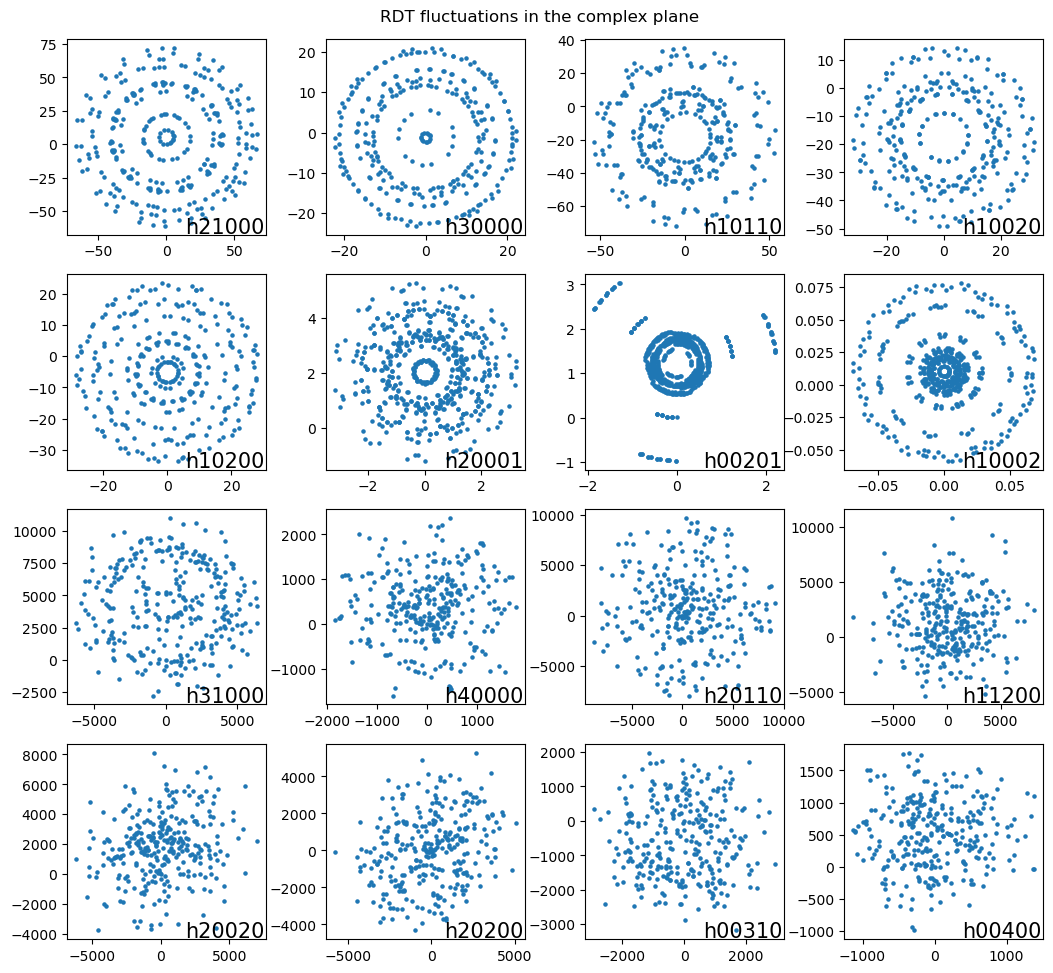

In [3]:
rdts_fluct = rdts.build_up_fluctuation(n_periods=14)  # The fluctuation of RDTs in the complex plane.
fig = plt.figure(figsize=(10.5, 10))
plt.subplots_adjust(left=0.05, right=0.98, bottom=0.05, top=0.95, wspace=0.3)
for i, k in enumerate(['h21000', 'h30000', 'h10110', 'h10020', 'h10200', 'h20001', 'h00201', 'h10002',
                       'h31000', 'h40000', 'h20110', 'h11200', 'h20020', 'h20200', 'h00310', 'h00400']):
    plt.subplot(4, 4, i + 1)
    plt.scatter(np.real(rdts_fluct[k]), np.imag(rdts_fluct[k]), s=5)
    plt.text(0.99, 0.01, k, transform=plt.gca().transAxes, size=15, horizontalalignment="right")
plt.suptitle('RDT fluctuations in the complex plane')
plt.show()

The fluctuation of third-order RDTs is simple.

With $N$ is the number of sextupoles of a cell and $w$ is the index of $w$-th sextupole in the cell,
the third-order RDT $h_{\vec{m}}$ at $(k N + w)$-th sextupole with k as a variable has two terms. 
For different sextupole index $w$, the $e^{i\vec{m}\cdot \vec{\mu}}$ terms of different $i$ are diffenrnt and the constant terms are the same. So there are concentric circles in the complex plane. When $w=N$, i.e. RDTs of multi-cell map, the third-order RDTs are on a circle passing the origin.

The fluctuation of fourth-order RDTs is more complex. see https://arxiv.org/abs/2303.14980
There are also constant term and $e^{i\vec{m}\cdot\vec{\mu}}$ terms for each $w$. And there are also $e^{i\vec{m}_1\cdot\vec{\mu}}$ terms and $e^{i\vec{m}_2\cdot\vec{\mu}}$ terms, where $\vec{m} = \vec{m}_1 + \vec{m}_2$.

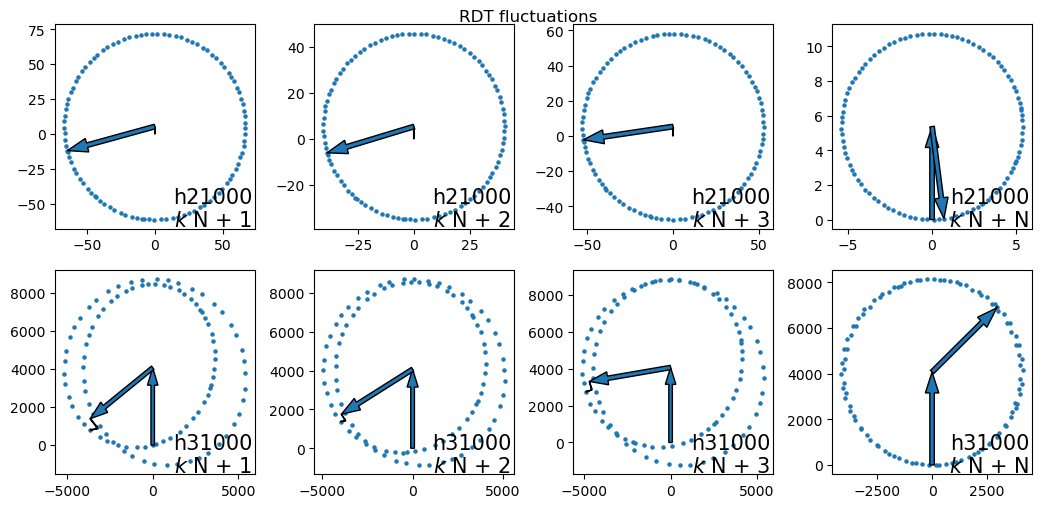

In [4]:
N = int(len(rdts_fluct['h21000']) / 14)
N_cell = 100
multi_cell_fluct = rdts.build_up_fluctuation(n_periods=N_cell)  # Here we calculate more cells to show the regularity.
fluct_comp = rdts.fluctuation_components()

fig = plt.figure(figsize=(10.5, 5))
plt.subplots_adjust(left=0.05, right=0.98, bottom=0.05, top=0.95, wspace=0.3)

for i in [0, 1, 2]:
    plt.subplot(2, 4, i + 1)
    for k in range(N_cell):
        plt.scatter(np.real(multi_cell_fluct['h21000'][int(k*N+i)]), np.imag(multi_cell_fluct['h21000'][int(k*N+i)]), c='C0', s=5)
    n_cell = 0
    r0 = complex(0, 0)
    for ratio, radius in fluct_comp['h21000']:
        r1 = radius[i] * ratio ** n_cell
        plt.arrow(r0.real, r0.imag, r1.real, r1.imag, length_includes_head=True, width=abs(r1) / 20)
        r0 = r0 + r1
    plt.text(0.99, 0.01, f'h21000\n$k$ N + {i+1}', transform=plt.gca().transAxes, size=15, horizontalalignment="right")
    plt.subplot(2, 4, i + 5)
    for k in range(N_cell):
        plt.scatter(np.real(multi_cell_fluct['h31000'][int(k*N+i)]), np.imag(multi_cell_fluct['h31000'][int(k*N+i)]), c='C0', s=5)
    n_cell = 10
    r0 = complex(0, 0)
    for ratio, radius in fluct_comp['h31000']:
        r1 = radius[i] * ratio ** n_cell
        plt.arrow(r0.real, r0.imag, r1.real, r1.imag, length_includes_head=True, width=abs(r1) / 20)
        r0 = r0 + r1
    plt.text(0.99, 0.01, f'h31000\n$k$ N + {i+1}', transform=plt.gca().transAxes, size=15, horizontalalignment="right")

    plt.subplot(2, 4, 4)
for k in range(N_cell):
    plt.scatter(np.real(multi_cell_fluct['h21000'][int(k*N - 1)]), np.imag(multi_cell_fluct['h21000'][int(k*N-1)]), c='C0', s=5)
n_cell = 10
r0 = complex(0, 0)
for ratio, radius in fluct_comp['h21000']:
    r1 = radius[-1] * ratio ** n_cell
    plt.arrow(r0.real, r0.imag, r1.real, r1.imag, length_includes_head=True, width=abs(r1) / 20)
    r0 = r0 + r1
plt.text(0.99, 0.01, f'h21000\n$k$ N + N', transform=plt.gca().transAxes, size=15, horizontalalignment="right")

plt.subplot(2, 4, 8)
for k in range(N_cell):
    plt.scatter(np.real(multi_cell_fluct['h31000'][int(k*N - 1)]), np.imag(multi_cell_fluct['h31000'][int(k*N-1)]), c='C0', s=5)
n_cell = 1
r0 = complex(0, 0)
for ratio, radius in fluct_comp['h31000']:
    r1 = radius[-1] * ratio ** n_cell
    plt.arrow(r0.real, r0.imag, r1.real, r1.imag, length_includes_head=True, width=abs(r1) / 20)
    r0 = r0 + r1
plt.text(0.99, 0.01, f'h31000\n$k$ N + N', transform=plt.gca().transAxes, size=15, horizontalalignment="right")
plt.suptitle('RDT fluctuations')
plt.show()

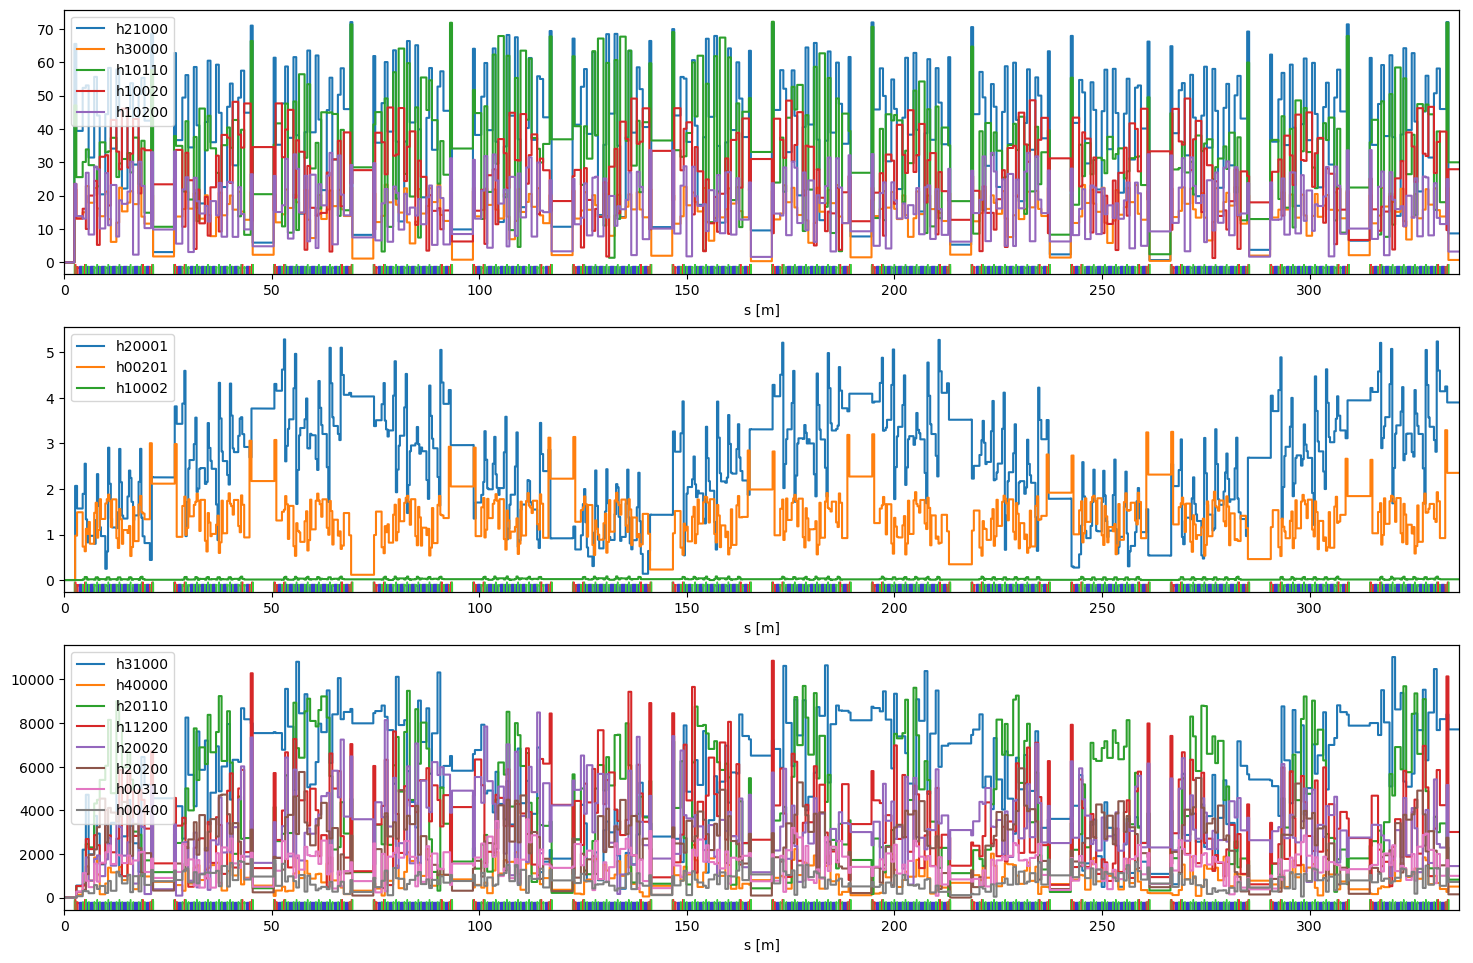

In [5]:
rdts_plot = ring.driving_terms_plot_data()  # This method calculates the fluctuation of RDTs along the ring.
fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(left=0.05, right=0.98, bottom=0.05, top=0.95, wspace=0.3)
ax1 = plt.subplot(3, 1, 1)
ax2 = plt.subplot(3, 1, 2)
ax3 = plt.subplot(3, 1, 3)
ax11 = ax1.twinx()
ax22 = ax2.twinx()
ax33 = ax3.twinx()
ssr.plot_layout_in_ax(ring.elements, ax11)
ssr.plot_layout_in_ax(ring.elements, ax22)
ssr.plot_layout_in_ax(ring.elements, ax33)
for k in ['h21000', 'h30000', 'h10110', 'h10020', 'h10200']:
    ax1.plot(rdts_plot['s'], np.abs(rdts_plot[k]), label=k)
ax1.legend()
for k in ['h20001', 'h00201', 'h10002']:
    ax2.plot(rdts_plot['s'], np.abs(rdts_plot[k]), label=k)
ax2.legend()
for k in ['h31000', 'h40000', 'h20110', 'h11200', 'h20020', 'h20200', 'h00310', 'h00400']:
    ax3.plot(rdts_plot['s'], np.abs(rdts_plot[k]), label=k)
ax3.legend()
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('s [m]')
    ax.set_xlim(0, ring.length)
plt.show()

There is another way to show the longitudinal variation RDTs. the RDTs of one-turn maps with different starting location are different. In ELEGANT, this kind of RDT fluctuations is calculated by  the 's_dependent_driving_terms' command.

In simplestoragering, we also use s_dependent_driving_terms() to calculate it.

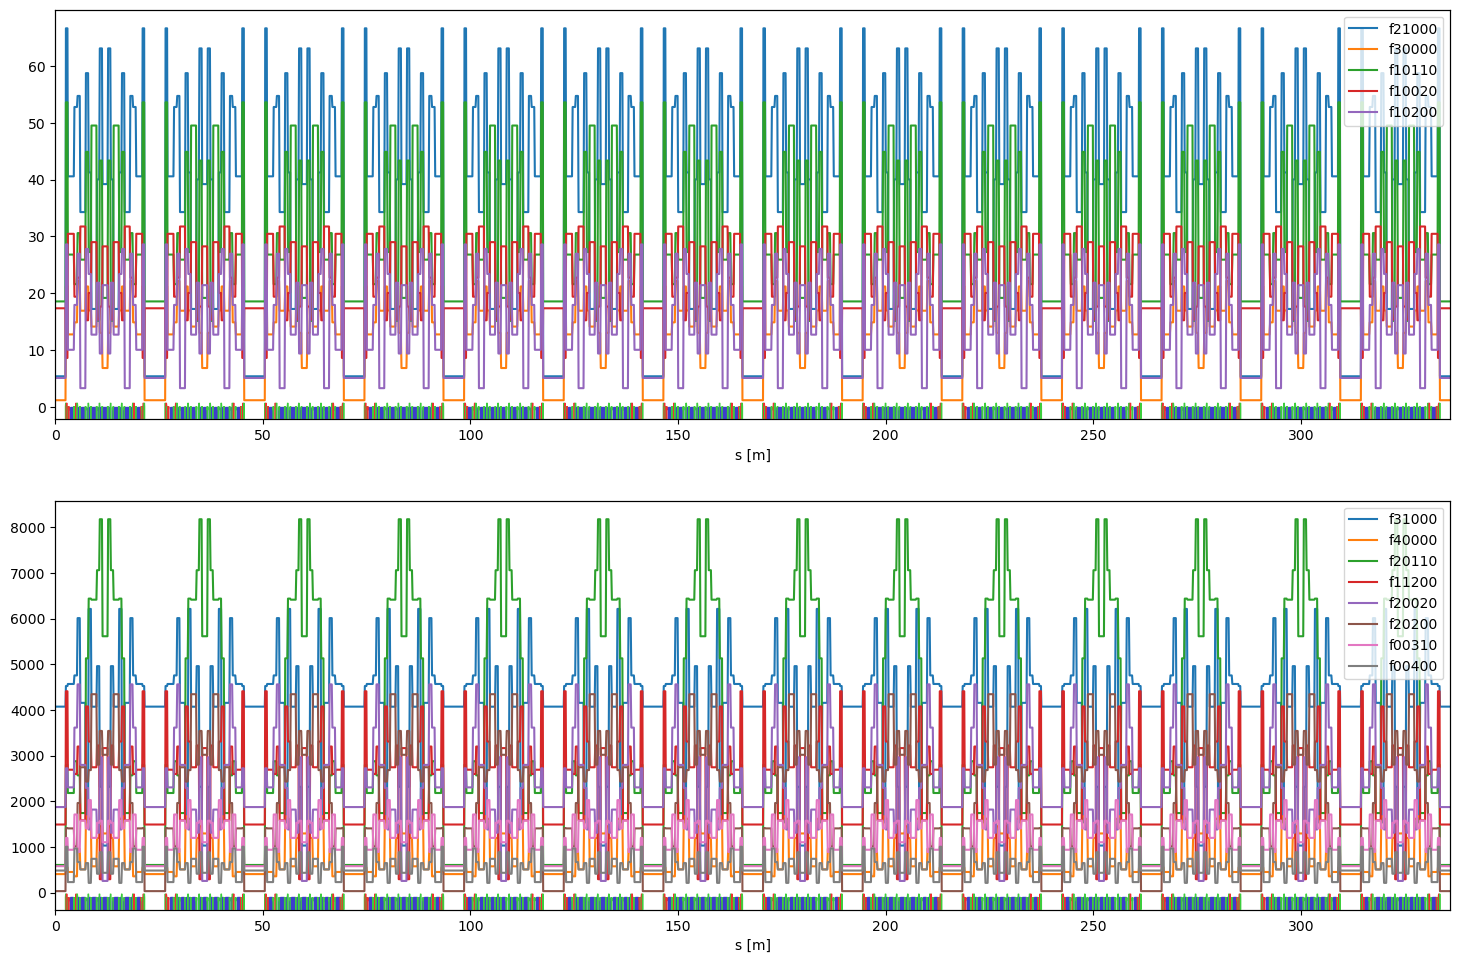

In [6]:
sddt = ring.s_dependent_driving_terms()
fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(left=0.05, right=0.98, bottom=0.05, top=0.95, wspace=0.3)
ax1 = plt.subplot(2, 1, 1)
ax3 = plt.subplot(2, 1, 2)
ax11 = ax1.twinx()
ax33 = ax3.twinx()
ssr.plot_layout_in_ax(ring.elements, ax11)
ssr.plot_layout_in_ax(ring.elements, ax33)
for k in ['f21000', 'f30000', 'f10110', 'f10020', 'f10200']:
    ax1.plot(sddt['s'], np.abs(sddt[k]), label=k)
ax1.legend()
for k in ['f31000', 'f40000', 'f20110', 'f11200', 'f20020', 'f20200', 'f00310', 'f00400']:
    ax3.plot(sddt['s'], np.abs(sddt[k]), label=k)
ax3.legend()
for ax in [ax1, ax3]:
    ax.set_xlabel('s [m]')
    ax.set_xlim(0, ring.length)
plt.show()

These two kinds of RDT fluctuations are related. The second fluctuation at $w$-th sextupole is exactly the $e^{i\vec{m}\cdot\vec{\mu}}$ term of the first fluctuation at $w$-th sextupole.

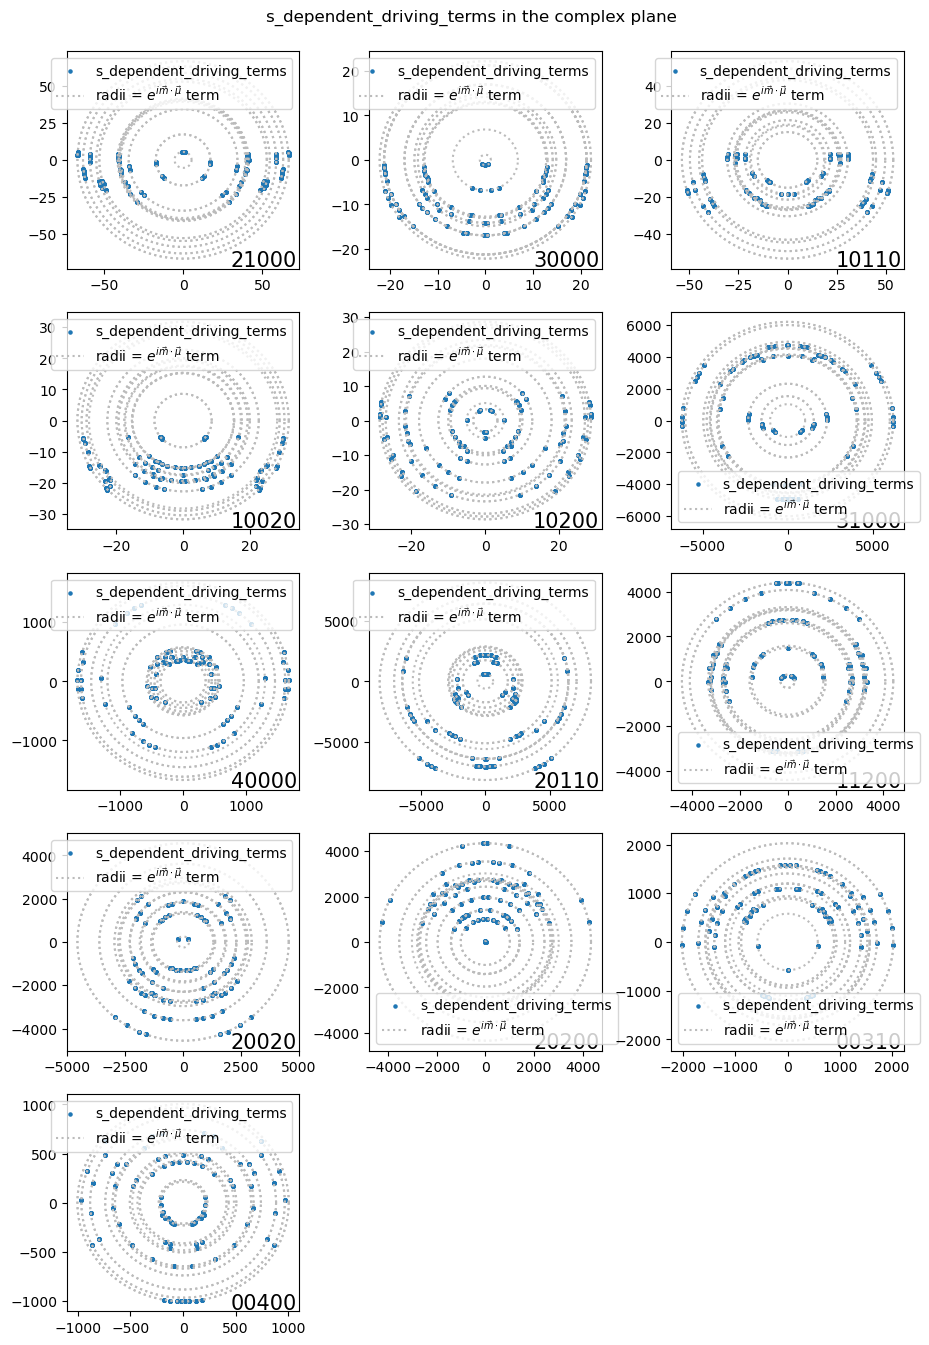

In [7]:
fig = plt.figure(figsize=(9, 14))
plt.subplots_adjust(left=0.05, right=0.98, bottom=0.05, top=0.95, wspace=0.3)
for i, k in enumerate(['21000', '30000', '10110', '10020', '10200',
                       '31000', '40000', '20110', '11200', '20020', '20200', '00310', '00400']):
    plt.subplot(5, 3, i + 1)
    r_list = np.abs(fluct_comp[f'h{k}'][1][1])
    for r in r_list:
        circle = r * np.exp(complex(0, 1) * np.linspace(0, 2 * np.pi, 100))
        line2, = plt.plot(np.real(circle), np.imag(circle), linestyle=':', c='#bbbbbb', label='radii = $e^{i\\vec{m}\\cdot \\vec{\mu}}$ term')
    line1 = plt.scatter(np.real(sddt[f'f{k}']), np.imag(sddt[f'f{k}']), s=5, label='s_dependent_driving_terms')
    plt.legend(handles=[line1, line2])
    plt.text(0.99, 0.01, k, transform=plt.gca().transAxes, size=15, horizontalalignment="right")
plt.suptitle('s_dependent_driving_terms in the complex plane')
plt.show()

##  higher order chromaticities 
Calculate the higher order chromaticities with the tunes of 4-d off-momentum closed orbit.

In [8]:
ring.higher_order_chromaticity()

xi2x: 18.82, xi2y: 39.44, xi3x: -1387.71, xi3y: -501.80


{'xi2x': 18.817979969942833,
 'xi2y': 39.44326961080602,
 'xi3x': -1387.7115150976817,
 'xi3y': -501.8001714429676}

## other functions

There are some functions help to visualize lattice data conviently.

`ssr.chromaticity_correction()`, `ssr.output_opa_file()` ......

Length =      336.000 m
angle =       360.000
abs_angle =   439.149
nux =         43.2994
nuy =         16.2985
I1 =        3.02603e-02
I2 =        6.30964e-01
I3 =        5.55012e-02
I4 =        -5.33537e-01
I5 =        1.12209e-05
energy =     2.20e+03 MeV
U0 =           208.10 keV
sigma_e =   7.358e-04
emittance = 6.847e-11 m*rad
Jx =           1.8456
Js =           1.1544
Tperiod =   1.121e-06 sec
alpha =     9.006e-05
eta_p =     9.001e-05
tau_e =         20.53 msec
tau_x =         12.84 msec
tau_y =         23.70 msec
natural_xi_x =   -107.72
natural_xi_y =    -47.69
xi_x =           2.38
xi_y =           1.78


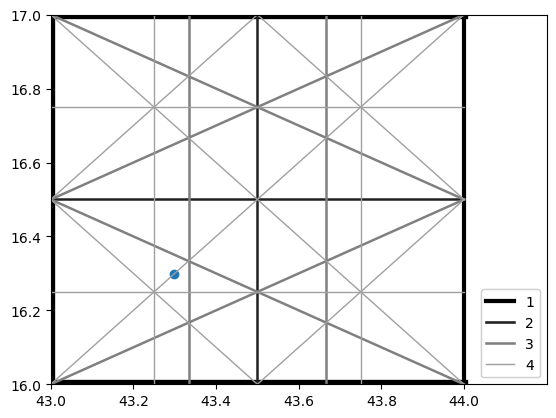

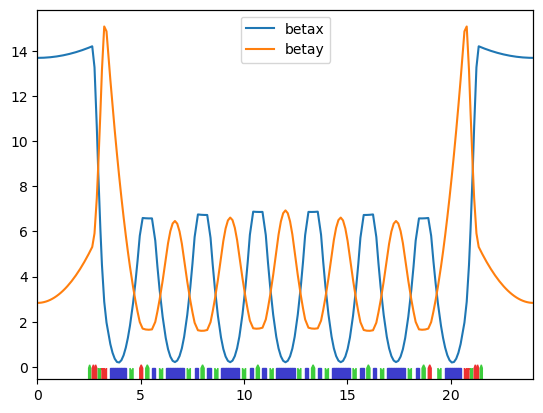

adjusted k2:  [-1.7822471494612344, 1.3647369583035251, -466.8076423926039, 673.9555250262632]
adjusted chromaticities:  2.9999999999999574 2.999999999999993


In [9]:
print(ring)
fig, ax = plt.subplots(1)
ax.scatter(ring.nux, ring.nuy)
ssr.plot_resonance_line_in_ax(ax, order=4, refnux=ring.nux, refnuy=ring.nuy)
plt.show()
ele_slices = cell.slice_elements(0.1, 0.1, 0.1, 0.1)  # slice elements to obtain smooth curves.
ssr.plot_lattice(ele_slices, ['betax', 'betay'])

# can not set the limit of sextupole strengths.
sext_k2 = ssr.chromaticity_correction(ring, sextupole_name_list=['SD1', 'SF1', 'SD2', 'SF2'], target=[3, 3])
ring.linear_optics()
print('adjusted k2: ', sext_k2)
print('adjusted chromaticities: ', ring.xi_x, ring.xi_y)

Use `help()` to obtain more information. 

Some other features are still to be improved.